# COVID-19

In this file, I want to analyze information on the papers published after the COVID-19 outbreak. 

First, I import all the necessary libraries. 

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

from re import search
import time

import googlemaps
from tqdm import trange

### You can skip to the Data section if the file 'Data.pkl' already exists.

## Reading the data:

I downloaded the list of papers and their characteristics for COVID-19 from the Embase data set. I included all the papers which included the following terms: 'COVID', 'Coronavirus disease 2019, and 'SARS-COV-2'. I also restricted the research to the papers with the main topic being COVID-19. The list of the papers is saved in different excel files (xls). The following codes read all the xls files in the folder, save them in a DataFrame called df. It also gets the name of each column from a different page of the excel file. Additionally, it selects the needed columns and creates a publication id for each document.

In [2]:
df = pd.DataFrame()
label= pd.DataFrame()
for f in glob.glob("*.xls"):
    dfi = pd.read_excel(f,header=1)
    df = df.append(dfi,ignore_index=True,sort=False)
    
    labeli=pd.read_excel(f,sheet_name="labels",header=None)
    label = label.append(labeli,ignore_index=True,sort=False)
    
label=label.drop_duplicates().reset_index(drop=True)

Column_dict = dict(zip(label[0], label[1]))

df=df.rename(columns=Column_dict)

df = df[['Title', 'Author(s)', 'Institution', 'Date Created', 'Language', 'Publication Type','Source', 'Abstract', 'Grant Information']]

df=df.dropna(axis='index',how='all')

df=df.dropna(subset=['Title'])

df=df.drop_duplicates().reset_index(drop=True)

df.head(5)

WARNING *** file size (4779521) not 512 + multiple of sector size (512)
WARNING *** file size (4779521) not 512 + multiple of sector size (512)
WARNING *** file size (4655105) not 512 + multiple of sector size (512)
WARNING *** file size (4655105) not 512 + multiple of sector size (512)
WARNING *** file size (4678657) not 512 + multiple of sector size (512)
WARNING *** file size (4678657) not 512 + multiple of sector size (512)
WARNING *** file size (5074945) not 512 + multiple of sector size (512)
WARNING *** file size (5074945) not 512 + multiple of sector size (512)
WARNING *** file size (4536321) not 512 + multiple of sector size (512)
WARNING *** file size (4536321) not 512 + multiple of sector size (512)
WARNING *** file size (5172225) not 512 + multiple of sector size (512)
WARNING *** file size (5172225) not 512 + multiple of sector size (512)
WARNING *** file size (4616705) not 512 + multiple of sector size (512)
WARNING *** file size (4616705) not 512 + multiple of sector siz

,Title,Author(s),Institution,Date Created,Language,Publication Type,Source,Abstract,Grant Information
0,"Erratum: Reply to letters addressing ""Chest CT...",Anonymous,NaN,20210402,English,Erratum,American Journal of Roentgenology. 216 (4) (pp...,The corrected version of the December 2020 Tab...,NaN
1,SARS-CoV-2 infection in mortuary and cemetery ...,Alishaq M.\n\nJeremijenko A.\n\nNafady-Hego H....,"(Alishaq, Jeremijenko, Nafady-Hego, Al Ajmi, F...",20210402,English,Article,International Journal of Infectious Diseases. ...,Background: Mortuary and cemetery workers may ...,NaN
2,Erratum: Department of Error (The Lancet (2021...,Anonymous,NaN,20210402,English,Erratum,"The Lancet. 397 (10278) (pp 970), 2021. Date o...",Commissioners of the Lancet COVID-19 Commissio...,NaN
3,Saliva twostep for rapid detection of asymptom...,Yang Q.\n\nMeyerson N.R.\n\nClark S.K.\n\nPaig...,"(Yang, Meyerson, Clark, Paige, Fattor, Gilchri...",20210402,English,Article,"eLife. 10 (no pagination), 2021. Article Numbe...","Here, we develop a simple molecular test for S...",Organization: *University of Colorado Boulder*...
4,Genomic and healthcare dynamics of nosocomial ...,Ellingford J.M.\n\nGeorge R.\n\nMcDermott J.H....,"(Ellingford, McDermott, Edgerley, Gokhale, New...",20210402,English,Article,"eLife. 10 (no pagination), 2021. Article Numbe...",Understanding the effectiveness of infection c...,NaN


We only consider the documents with one of the following publication types: Article, Chapter, Review, Letter, Note, and Editorial.

In [3]:
PT=['Article', 'Chapter', 'Review', 'Letter', 'Note', 'Editorial']

df = df[df['Publication Type'].isin(PT)].reset_index(drop=True)

df=df.drop(columns=['Publication Type'])

df['Publication ID'] = df.index

Publication_ID=np.unique(df['Publication ID'])

## Number of authors:

The following codes calculate the number of authors for each publication.

In [4]:
Authors =df['Author(s)'].str.split(pat ='\n' , expand = True)

df['Number of Authors']=((Authors!='')&(~Authors.isnull())).sum(axis=1)

## Length of publications:

For the next step, I want to calculate the number of pages in each publication. The column 'Source' has information about page number of the article in the journal. For example, the column would include '(pp 527-528)', which means the article starts on page 527 and end on page 528. Sometimes the Roman numeric is used to report the page numbers. The following function will convert them into integers. 

In [5]:
rom_val = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
def roman_to_int(s):
    s=s.upper()
    int_val = 0
    for i in range(len(s)):
        if i > 0 and rom_val[s[i]] > rom_val[s[i - 1]]:
            int_val += rom_val[s[i]] - 2 * rom_val[s[i - 1]]
        else:
            int_val += rom_val[s[i]]
    return str(int_val)

First, I create the variable 'pages' which has information about the page numbers. A document could be published in different parts of a journal. Here I separate different ranges of page numbers.

In [6]:
Source=df.Source

pages = np.empty(len(Source), dtype=object)

for i in range(len(Source)):
    pa=re.search(r'\(pp(.*?)\)', Source[i])
    if pa:
        pages[i]=pa.group(1)
        
pages=pd.DataFrame(pages,columns=['Page'])


pages.Page=pages.Page.str.replace(',', '+')

pages.Page=pages.Page.str.replace('and', '+')


pages=pages.Page.str.split(pat ='+', expand = True)

Ncol_Pages=pages.shape[1]

Pag_Col=['Pb-%s' % i  for i in range(pages.shape[1])]+['Pe-%s' % i  for i in range(pages.shape[1])]

Pages = pd.DataFrame(index = range(pages.shape[0]), columns = Pag_Col)


for i in range(pages.shape[1]):
    Page_Split=pages[i].str.split(pat ='-', expand = True)
    
    for j in range(pages.shape[0]):
        lrp=len(Page_Split.iloc[j].dropna())
        if lrp<2:
            nb=ne=0
        else:
            nb=round((lrp/2)-1)
            ne=lrp-1

        Pages.loc[j,'Pb-%s' % i]=Page_Split.loc[j,nb]
        Pages.loc[j,'Pe-%s' % i]=Page_Split.loc[j,ne]
        
for col in Pages.columns:
    Pages[col]=Pages[col].str.strip()

The information about appendices is also reported in the 'Source' column. This information is separated from the page number by '.e'. For example '(pp 527-528.e5)' means the publication has 5 pages of appendices. Here I extract the information for appendices.

In [7]:
for col in Pages.columns:
    Pages[col]=Pages[col].str.upper()
    
for col in Pages.columns:
    Pages[col]=Pages[col].str.strip('E')
        
for col in Pages.columns:
    Page_Appendix=Pages[col].str.split(pat ='E' , n = 1, expand = True)
    
    Pages[col]=Page_Appendix[0]
    
    Pages['A-%s' % col]=None
    
    if Page_Appendix.shape[1]==2:
        Pages['A-%s' % col]=Page_Appendix[1]
        
for col in Pages.columns:
    Pages[col]=Pages[col].str.strip()

Next, I convert the Roman numbers into digits and clean the data.

In [8]:
for col in Pages.columns:
    for j in range(Pages.shape[0]):
        if Pages[col][j]!=None:
            if ((any(char.isdigit() for char in Pages[col][j])==False) & any(Pages[col][j].upper().startswith(s) for s in rom_val.keys())):
                Pages[col][j]=roman_to_int(Pages[col][j])
                               
for col in Pages.columns:
    Pages[col]=Pages[col].str.split(pat ='.', expand = True).replace(r'^\s*$', np.nan, regex=True).fillna(method='ffill',axis=1).iloc[:,-1]
    Pages[col]=Pages[col].str.split(pat ='OF', expand = True)[0]
    Pages[col]=Pages[col].str.strip()
    
for col in Pages.columns:
    for j in range(Pages.shape[0]):
        if isinstance(Pages[col][j], str):
            Pages[col][j]=re.sub('\D', '', Pages[col][j])
            
Pages = Pages.replace(r'^\s*$', np.NaN, regex=True)

Pages = Pages.fillna("NaN")

for i in range(Ncol_Pages):
    for j in range(Pages.shape[0]):
        if len(Pages['Pe-%s' % i][j]) < len(Pages['Pb-%s' % i][j]):
            Pages.loc[j,'Pb-%s' % i]=Pages.loc[j,'Pb-%s' % i][-len(Pages['Pe-%s' % i][j]):]

for col in Pages.columns:
    Pages[col]=pd.to_numeric(Pages[col], errors='coerce')
    
Apendix_col = [col for col in Pages if col.startswith('A')]
for col in Apendix_col:
    Pages[col] = Pages[col].fillna(0)

In the end, I calculate the number of pages and create a new column for DataFrame 'df' to store that. 

In [9]:
Pages['Dif']=abs(Pages['Pe-%s' % 0]-Pages['Pb-%s' % 0])+1
Pages['Dif'][~np.isnan(Pages['Dif'])]=0

for j in range(Pages.shape[0]):
    for i in range(Ncol_Pages):
        dif=abs(Pages['Pe-%s' % i][j]-Pages['Pb-%s' % i][j])+1
        if ~np.isnan(dif):
            Pages.loc[j,'Dif']=Pages.loc[j,'Dif']+dif
        Pages.loc[j,'Dif']=Pages.loc[j,'Dif']+abs(Pages['A-Pe-%s' % i][j]-Pages['A-Pb-%s' % i][j])

Pages.loc[(Pages['Dif'] > 100), 'Dif']=np.nan

df['Length of publications']=Pages.Dif

## Animal Origins

Here I search in the title of each paper to see if it mentions any of the following words: Zoo, Bat, Mammal, Mosquito, Bird, Pangolin, Pig, Swine, Animal, Aedes, porcine, pork, primate, reservoir, host, chiropteran, placental, eutherian.

In [10]:
df['Abstract']=df.Abstract.fillna('')

animal_wordL=['zoo', 'bat', 'mammal', 'mosquito', 'bird', 'pangolin', 'pig', 'swine', 'animal', 'aedes', 'porcine', 'pork', 'primate', 'reservoir', 'host', 'chiropteran', 'placental', 'eutherian']

animal_wordL  = [el.upper() for el in animal_wordL]

df['Animal_Origin']=False

for i in trange(len(df)):
    for j in range(len(animal_wordL)):
        if animal_wordL[j] in df.Title[i].upper():
            df.loc[i,'Animal_Origin']=True
            break
            
df['One_Health']=False
one_health='ONE HEALTH'
for i in trange(len(df)):
    if (one_health in df.Title[i].upper()) or (one_health in df.Abstract[i].upper()):
        df.loc[i,'One_Health']=True

100%|███████████████████████████████████████████████████████████████████████| 113357/113357 [00:05<00:00, 21437.93it/s]


## Vaccine and Diagnostic

Here I search in the title and abstract of each paper to see if they mention "Vaccine" or "Diagnostic".

In [11]:
df['Vaccine']=False
Vaccine='VACCINE'
for i in trange(len(df)):
    if (Vaccine in df.Title[i].upper()) or (Vaccine in df.Abstract[i].upper()):
        df.loc[i,'Vaccine']=True
            
df['Diagnostic']=False
Diagnostic='DIAGNOSTIC'
for i in trange(len(df)):
    if (Diagnostic in df.Title[i].upper()) or (Diagnostic in df.Abstract[i].upper()):
        df.loc[i,'Diagnostic']=True

100%|███████████████████████████████████████████████████████████████████████| 113357/113357 [00:07<00:00, 15990.99it/s]


## Countries involved:

In the next step, I want to extract information about the country of each other. This information can be found in the 'Institution' column. This column lists the institution which each author is associated with. It also has the address of each institution, which can be used to extract the countries involved. The first step is to expand the data and have the information of different institutions in different rows. So, the paper will have several rows, each of them with information from different institutions. The result is saved in a new DataFrame 'data'. 

In [12]:
data=df.assign(Institution=df['Institution'].str.split(pat ='\n'))

data=data.explode('Institution').reset_index(drop=True)

Next I get the category of each country from WHO data. I also create a list for country names.

In [13]:
Country_category=pd.read_excel('WB-class-rank.xlsx',header=4)

Country_category=Country_category[['Economy','Income group']].dropna(subset=['Income group']).reset_index(drop=True)

Country_category=Country_category.rename(columns={'Economy':'Countries'})

Country_Category_Map={'Micronesia, Fed. Sts.':'Micronesia','Venezuela, RB':'Venezuela','Congo, Dem. Rep.':'Congo','Taiwan, China':'Taiwan','Hong Kong SAR, China':'Hong Kong','Korea, Rep.':'South Korea', 
                      'Iran, Islamic Rep.':'Iran','Korea, Dem. People\'s Rep.':'North Korea','Kyrgyz Republic':'Kyrgyzstan','Macao SAR, China':'Macao',
                      'Egypt, Arab Rep.':'Egypt', 'Bahamas, The':'Bahamas','Slovak Republic':'Slovakia','Brunei Darussalam':'Brunei','Lao PDR':'Laos','Yemen, Rep.':'Yemen', 'Syrian Arab Republic':'Syria',
                     'Russian Federation':'Russia','Côte d\'Ivoire':'Cote D\'Ivoire','Gambia, The':'Gambia','Czech Republic':'Czechia','North Macedonia':'Macedonia','Cabo Verde':'Cape Verde'} 

for i in range(Country_category.shape[0]):
    if Country_category.Countries[i] in Country_Category_Map.keys():
        Country_category.loc[i,'Countries']=Country_Category_Map[Country_category.Countries[i]]

        
country_list= list(Country_category.Countries)

Extra_Country_Names=['Brasil','Deutschland','Swaziland','Espana','Cabo Verde','Côte d\'Ivoire','Lao PDR','Kyrgyz Republic','Czech Republic','Slovak Republic',
                     'Puerto Rico','Northern Ireland','Wales','Scotland','England']

Country_List=country_list+list(Extra_Country_Names)


Extra_Country_map={'Brasil':'Brazil','Deutschland':'Germany','Swaziland':'Eswatini','Espana':'Spain', 'Puerto Rico':'United States','England':'United Kingdom',
                   'Scotland':'United Kingdom', 'Wales':'United Kingdom', 'Northern Ireland':'United Kingdom', 'UK':'United Kingdom', 'USA':'United States'}

Country_Category_Map.update(Extra_Country_map)

Next, I extract the last section of the column 'Institution' as the name of the countries. I also check if the column 'Institution' include any of name of the countries from country list.

In [14]:
data['Institution']=data['Institution'].str.strip(',.-')

data['Institution'] = data.Institution.fillna('')

data['Institution'] = data.Institution.str.replace('\(.*?\)', '', 1)

data['Institution'] = data.Institution.str.replace(';', ',')


data['Countries'] = data.Institution.str.split(pat =',', expand = True).ffill(axis=1).iloc[:, -1]

data['Countries'] = data['Countries'].str.replace(r'[;+.,\\]', '') 

data['Countries']=data['Countries'].str.strip()


for i in trange(len(data)):
    for j in range(len(Country_List)):
        if search(Country_List[j], data.Institution[i]):
            data.loc[i,'Countries']=Country_List[j]
            break

100%|████████████████████████████████████████████████████████████████████████| 419033/419033 [2:22:39<00:00, 48.96it/s]


The following lines of codes search the name of institutions in the Google maps data set and extract the name of the countries. You can **skip this step** if the file "CountriesMap.xlsx" already exists. You have to replace the Maps API key with your own key. For more information visit [this link](https://github.com/googlemaps/google-maps-services-python). 

In [ ]:
gmaps = googlemaps.Client(key='Your Maps API key')

key_words=['University','Universitat','Hochschule','Universit','Universid','Hospital','Krankenhaus','Landesspital','Ospedal', 'Foundation','Fundacion','Institut','Istituto','School of Medicine']

Countries=data[['Title','Institution','Countries']].drop_duplicates(subset=['Countries'], keep='last').reset_index(drop=True)

Countries = Countries.fillna('')

Countries['Mapped']=Countries.Countries

for i in trange(len(Countries)):
    if Countries.Countries[i] not in Country_List:
        Institution_split=Countries.Institution[i].split(',')
        for key in range(len(key_words)):
            key_match=False
            for j in range(len(Institution_split)):
                if key_words[key].upper() in Institution_split[j].upper():
                    Institution_split[j] = re.sub(r'\(.*?\)', '', Institution_split[j])
                    Institution_address=gmaps.find_place(Institution_split[j], input_type='textquery', fields= ['formatted_address'])
                    try:
                        Countries.loc[i,'Mapped']=Institution_address['candidates'][0]['formatted_address']
                        key_match=True
                        break
                    except:
                        key_match=False
            if key_match:
                break
                
for i in trange(len(Countries)):
    dummy=True
    for j in range(len(Country_List)):
        if (Country_List[j] in Countries.Mapped[i]):
            Countries.loc[i,'Mapped']=Country_List[j]
            dummy=False
            break
    if dummy:
        Countries.loc[i,'Mapped']=Countries.loc[i,'Mapped'].split(',')[-1]
        
Countries.Mapped=Countries.Mapped.str.strip()

for i in trange(len(Countries)):
    if Countries.Mapped[i] not in Country_List:
        Mapped_types=''
        try:
            Mapped_types=gmaps.find_place(Countries.Mapped[i], input_type='textquery', fields= ['types'])['candidates'][0]['types'][-1]
            if Mapped_types=='political':
                Countries.loc[i,'Mapped']=gmaps.find_place(Countries.Mapped[i], input_type='textquery', fields= ['formatted_address'])['candidates'][0]['formatted_address'].split(',')[-1]
        except:
            pass

Countries.Mapped=Countries.Mapped.str.strip()

for i in range(len(Countries)):
    if Countries.Mapped[i] in Country_Category_Map.keys():
        Countries.loc[i,'Mapped']=Country_Category_Map[Countries.Mapped[i]]
        
Countries.drop_duplicates(subset=['Countries'], keep='last').sort_values(by=['Mapped']).reset_index(drop=True).to_excel('Countries_Map.xlsx',index=False)

Google map uses IP address biasing by default, so it has a tendency to find places in Canada. We need to check places matched with Canada in 'Countries_Map.xlsx' and correct them manually.

In [15]:
CountriesMap = pd.read_excel("CountriesMap.xlsx",header=0)

CountriesMap=dict(zip(CountriesMap.Countries, CountriesMap.Mapped))

for i in trange(len(data)):
    if data.Countries[i] in CountriesMap.keys():
        data.loc[i,'Countries']=CountriesMap[data.Countries[i]]
        
for i in trange(len(data)):
    if data.Countries[i] not in country_list:
        data.loc[i,'Countries']=''

100%|████████████████████████████████████████████████████████████████████████| 419033/419033 [01:28<00:00, 4741.39it/s]


Now we can add the income group of each country.

In [16]:
data=data.merge(Country_category, on='Countries', how='left')      

Next, we calculate the number of countries involved in the publication. 

In [17]:
data['Number of Countries']=0

for ID in Publication_ID:
    lc=np.unique(data[data['Publication ID']==ID].Countries)
    lc=lc[lc!='']
    data.loc[data['Publication ID']==ID, ['Number of Countries']] = len(lc)
    
data.loc[(data['Number of Countries']==0), 'Number of Countries']=np.nan

## Industry ties 

Now, I want to identify all the authors with industry ties. I use the column 'Institution' for this part as well. To check in any of the institutions listed in this data set are from industry, I use the sponsor data from ClinicalTrials.gov. I match sponsors from the industry from that data set with the 'Institution' listed for each author. 

First, I clean the sponsor data. I define the list of general words used in the name of companies as 'General_words'. If the name of a sponsor is only made of these words, they can match with some descriptions in the 'Institution' column. So, I ignore them if they do not have any specific words in the name of the sponsors. I also define the list for the type of a company as 'Business_structure'. The name of a company may or may not include these words in different lists, so I delete them from both lists I want to match with each other. I also delete all the parenthesizes and punctuation. Additionally, the list 'Non_profits' is used to exclude non-profit organizations.

In [18]:
sponsors = pd.read_csv(r"sponsors.txt", sep='|')

sponsors=sponsors[['agency_class','name']]
sponsors=sponsors[sponsors.agency_class=='Industry']
sponsors=sponsors[['name']]
sponsors=sponsors.rename(columns={'name':'Sponsors'})

sponsors=sponsors.drop_duplicates().reset_index(drop=True)

sponsors['Original Name']=sponsors.Sponsors

General_words=['AB','for','Humana','GmbH', 'Limited', 'AS', 'Focus','Diagnostics','Mind','Response','Discovery','Dimension','Therapy','Community','Origin','Cellular','Foundation','Protection','Clinical','Performance', 
               'Health','Tissue','Laboratories','Evolution','Morphogenesis','Medical', 'Entomology', 'Biologics','Lung','Biology','Applied','Functional','Integrated','Technology', 'Advanced','New','International',
               'Biomedical','Life','Biosciences', 'Institut','Institute', 'Research','Center','Centre', '&','Translational', 'Science', 'Sciences','Medicine', 'Stem', 'Cell', 'Management','University', 
               'Therapeutics', 'United','Systems', 'Neuroscience', 'Genetics', 'Molecular']

Business_structure=['Inc', 'Ltd', 'Corp', 'LLC', 'AG', 'BV', 'KG',  'Co', 'Pty', 'Plc']

General_words  = [el.upper() for el in General_words ]

Business_structure  = [el.upper() for el in Business_structure]

for i in range(len(sponsors)):
    sponsors.Sponsors[i]=re.sub(r'\((.*?)\)', '', sponsors.Sponsors[i])
    sponsors.Sponsors[i]=re.sub(r'[+.,\\]', '', sponsors.Sponsors[i])
    if (not all(el in (General_words+Business_structure) for el in set(sponsors.Sponsors[i].upper().split()))):
        sponsors.Sponsors[i]=re.sub(r'Inc$|Ltd$|corp$|LLC$|AG$|AB$|BV$|GmbH$|KG$|AS$|Limited$|Co$|Spa$|Pty|plc$', '', sponsors.Sponsors[i], flags=re.I).rstrip()
        sponsors.Sponsors[i]=re.sub(r'Inc$|Ltd$|corp$|LLC$|AG$|AB$|BV$|GmbH$|KG$|AS$|Limited$|Co$|Spa$|Pty|plc$', '', sponsors.Sponsors[i], flags=re.I).rstrip()
    if all(el in General_words for el in set(sponsors.Sponsors[i].upper().split())):
        sponsors.Sponsors[i]=None
        
sponsors=sponsors.dropna(subset=['Sponsors'])

Non_profits=['Institut Pasteur','Burroughs Wellcome']

for el in Non_profits:
    sponsors=sponsors[sponsors.Sponsors!=el]
    
sponsors.Sponsors=' '+sponsors.Sponsors+' '

sponsors=sponsors.drop_duplicates().reset_index(drop=True)

#sponsors.to_excel('Sponsors.xls',index=False)

Next, I clean the data in the 'Institution' column. I delete the words in parenthesize, which are the name of authors and some extra explanations. I only consider the first two sections of the data in this column. The rest of the data is usually the address of the institution. I also delete all the punctuation. 

In [19]:
for i in trange(len(data)):
    data.loc[i,'Institution']=re.sub(r'^\((.*?)\)', '', data.loc[i,'Institution'],1).lstrip()

Inst =data.Institution.str.split(pat =',' , expand = True)

Inst = Inst.replace(np.nan, '', regex=True)

data.Institution=(Inst[0]+Inst[1]).str.strip()

for i in trange(len(data)):
    data.loc[i,'Institution']=re.sub(r'[+.,\\]', '', data.loc[i,'Institution'])
    
data=data.drop_duplicates().reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████| 419033/419033 [3:40:37<00:00, 31.65it/s]


I also look into the grant information for each publication to see if they are related to industries. Each publication might receive several grants. Here I clean the 'Grant Information' column and store each grant in a different row. I store the expanded rows in the 'Data' DataFrame.

In [20]:
Data=data.assign(Grant=data['Grant Information'].str.split(pat ='\n'))

Data=Data.explode('Grant').reset_index(drop=True)

Data=Data.drop(columns=['Grant Information'])

for i in trange(Data.shape[0]):
    if isinstance(Data.Grant[i], str):
        Gr=re.search(r'\*(.*?)\*', Data.Grant[i])
        if Gr:
            Data.loc[i,'Grant']=Gr.group(1).strip()

100%|█████████████████████████████████████████████████████████████████████████| 518470/518470 [51:40<00:00, 167.24it/s]


Now I define a list of words that if a name includes them, they will not be considered 'Industry'.

In [21]:
Excluded=['University', 'College']

Excluded  = [el.upper() for el in Excluded]

Next, I check if each of the names in the 'Grant' column is from the industry. To do that I define a new DataFrame called 'grant' with grant information and delete the duplicates row. I define a new column called 'Agency Class' and set it equal to 'Other' by default. Then if the 'Grant' column includes any of the words in the 'Business_structure' list, the 'Agency Class' would change to the industry. If it includes any word from the 'Excluded' list it will stay 'Other'. The rest of the names will be matched with sponsor data from clinical trials. If it matches with any name from there,'Agency Class' would change to the industry. The matched names are saved in an excel file called 'Grant_matched'. This file should be manually checked to make sure all the matches are correct. If the matching is incorrect, the column 'Correction' should be changed to 1. I changed the name of the file to 'GrantMatched.xlsx' to avoid accidental rewrite.

This step might take several minutes to run. So the result is saved in an excel file called 'grant.xlsx' and if this file already exists, **the next two steps can we skipped*** in a rerun of the program (skipping only one of them can cause error).

In [30]:
grant=Data[['Grant']].drop_duplicates().dropna().reset_index(drop=True)

grant.Grant=' '+grant.Grant+' '

grant['Agency Class']='Other'

Grant_matched=pd.DataFrame(columns=['Sponsors', 'Grant'])

for i in trange(len(grant)):
    if any(check in set(grant.Grant[i].upper().split()) for check in Business_structure):
        grant['Agency Class'][i]='Industry'
    elif any(el in set(grant.Grant[i].upper().split()) for el in Excluded):
        grant['Agency Class'][i]='Other'
    else:
        for j in range(len(sponsors)):
            if (sponsors.Sponsors[j] in grant.Grant[i]):
                grant['Agency Class'][i]='Industry'
                mat={'Sponsors' : sponsors.Sponsors[j] , 'Grant' : grant.Grant[i]}
                Grant_matched=Grant_matched.append(mat,ignore_index=True)
            

Grant_matched=Grant_matched.drop_duplicates().reset_index(drop=True)

Grant_matched['Correction']=0

Grant_matched.to_excel('Grant_Matched.xlsx',index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [09:12<00:00,  3.08it/s]


In [31]:
Grant_matched = pd.read_excel('GrantMatched.xlsx')

Corrections=list(Grant_matched[Grant_matched.Correction==1]['Grant'])

for i in range(len(grant)):
    if grant.Grant[i] in Corrections:
        grant['Agency Class'][i]='Other'
        
grant.to_excel('grant.xlsx',index=False)

Similarly, I check if each of the names in the 'Institution' column is from the industry.

This step might take several hours to run. So the result is saved in an excel file called 'institution.xlsx'. If this file already exists, ***this step can we skipped*** in a rerun of the program.

In [32]:
institution=Data[['Institution']].drop_duplicates().dropna().reset_index(drop=True)

institution.Institution=' '+institution.Institution+' '

institution['Agency Class']='Other'

Institution_matched=pd.DataFrame(columns=['Sponsors', 'Institution'])

for i in trange(len(institution)):
    if any(el in set(institution.Institution[i].upper().split()) for el in Business_structure):
        institution['Agency Class'][i]='Industry'
    elif any(el in set(institution.Institution[i].upper().split()) for el in Excluded):
        institution['Agency Class'][i]='Other'
    else:
        for j in range(len(sponsors)):
            if (sponsors.Sponsors[j] in institution.Institution[i]):
                institution['Agency Class'][i]='Industry'
                mat={'Sponsors' : sponsors.Sponsors[j] , 'Institution' : institution.Institution[i]}
                Institution_matched=Institution_matched.append(mat,ignore_index=True)
                
                
Institution_matched=Institution_matched.drop_duplicates().reset_index(drop=True)

Institution_matched['Correction']=0

Institution_matched.to_excel('Institution_Matched.xlsx',index=False)

100%|████████████████████████████████████████████████████████████████████████| 115799/115799 [8:41:57<00:00,  3.70it/s]


In [33]:
Institution_matched = pd.read_excel('InstitutionMatched.xlsx')

Corrections=list(Institution_matched[Institution_matched.Correction==1]['Institution'])

for i in range(len(institution)):
    if institution.Institution[i] in Corrections:
        institution['Agency Class'][i]='Other'
        
institution.to_excel('institution.xlsx',index=False)

Next, I read the saved excel files and merge the industry lists with the main data.

In [22]:
grant = pd.read_excel('grant.xlsx')
grant.Grant=grant.Grant.str.strip()

institution=pd.read_excel('institution.xlsx')
institution.Institution=institution.Institution.str.strip()


Data=Data.merge(institution, on='Institution', how='left')
Data=Data.rename(columns={'Agency Class':'Institution Agency Class'})

Data=Data.merge(grant, on='Grant', how='left')
Data=Data.rename(columns={'Agency Class':'Grant Agency Class'})

Data['Institution Agency Class'] = Data['Institution Agency Class'].fillna('')
Data['Grant Agency Class'] = Data['Grant Agency Class'].fillna('')

Now I create a new column 'Industry', which is 'True' for a publication if one of the rows of the publication for 'Institution Agency Class' or 'Grant Agency Class' is 'Industry'.

In [23]:
Data['Industry']=False
for ID in Publication_ID:
    Ac_Inst=list(np.unique(Data[Data['Publication ID']==ID]['Institution Agency Class']))
    Ac_Gran=list(np.unique(Data[Data['Publication ID']==ID]['Grant Agency Class']))
    Ac=Ac_Inst+Ac_Gran
    if 'Industry' in Ac:
        Data.loc[Data['Publication ID']==ID, ['Industry']] = True

Next, I save the data in a file called 'Data.pkl'. The next section will read this data. So, you can skip running the previous sections of the program, if this file is available.

In [24]:
Data.to_pickle('Data.pkl')

## Date

Now I read the data set from the saved file. 

In [52]:
Data= pd.read_pickle('Data.pkl')

Next, I clean the column 'Date Created'. I also set the beginning and end date for the data to be included. For the time segmentation to work properly, the beginning date should be the first day of a month and the end date should be the end date of another month. I save the trimmed data set in a new DataFrame called 'DATA'.

In [72]:
Data['Date Created']=pd.to_datetime(Data['Date Created'], format='%Y%m%d', errors='ignore')

Data=Data.sort_values(by=['Date Created']).reset_index(drop=True)

Start_date='2020-01-01'
End_data='2021-03-31'
DATA=Data[Data['Date Created']>=Start_date]
DATA=DATA[DATA['Date Created']<End_data].reset_index(drop=True)

In [73]:
for col in ['Abstract','Language','Institution','Grant','Countries']:
    DATA[col]=DATA[col].str.strip()
    
DATA=DATA.replace(r'^\s*$', np.NaN, regex=True)

DATA.loc[(DATA['Institution'].isnull() & DATA['Grant'].isnull()), 'Industry']=np.nan

## Results

This section presents the different trends observed in the data set.

### Number of publications

First, I show how the number of publications in change by time. The variable 'freq' set the length of each time period. 

In [74]:
Count_Publication=DATA[['Publication ID','Date Created']].drop_duplicates().reset_index(drop=True)

Count_Publication=Count_Publication.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Count_Publication=Count_Publication.agg('count')

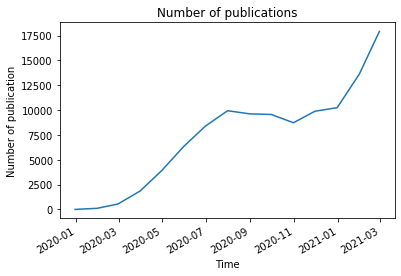

In [75]:
fig, ax = plt.subplots()

ax.plot(Count_Publication.index, Count_Publication)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Number of publication')

plt.title('Number of publications')

plt.show()

fig.savefig('Number_publications.png')

plt.close(fig)

### Language

Next, I look into how the share of English publications changes over time.

In [76]:
Language=DATA[['Publication ID','Language','Date Created']].drop_duplicates().dropna(subset=['Language']).reset_index(drop=True)

Language['English']= (Language['Language']=='English')

Language=Language.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Language=Language[['English']].agg('mean')

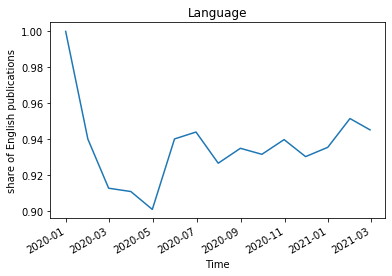

In [77]:
fig, ax = plt.subplots()

ax.plot(Language.index, Language)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('share of English publications')

plt.title('Language')

plt.show()

fig.savefig('Language.png')

plt.close(fig)

### Number of Countries

Now, I look at how the number of countries involved in publications changes by time

In [78]:
Number_Countries=DATA[['Publication ID','Number of Countries','Date Created']].drop_duplicates().dropna(subset=['Number of Countries']).reset_index(drop=True)

Number_Countries=Number_Countries.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Number_Countries=Number_Countries[['Number of Countries']].agg('mean')

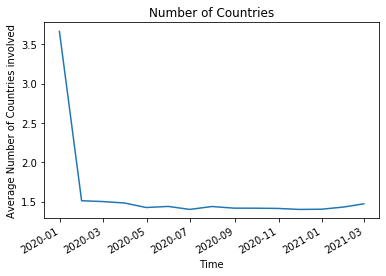

In [79]:
fig, ax = plt.subplots()

ax.plot(Number_Countries.index, Number_Countries)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Average Number of Countries involved')

plt.title('Number of Countries')

plt.show()

fig.savefig('Number_Countries.png')

plt.close(fig)

### Animal Origin

Next, I show how the portion of publications with animal origin changes over time.

In [80]:
Animal_Origin=DATA[['Publication ID','Animal_Origin','Date Created']].drop_duplicates().dropna(subset=['Animal_Origin']).reset_index(drop=True)

Animal_Origin=Animal_Origin.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Animal_Origin=Animal_Origin[['Animal_Origin']].agg('mean')

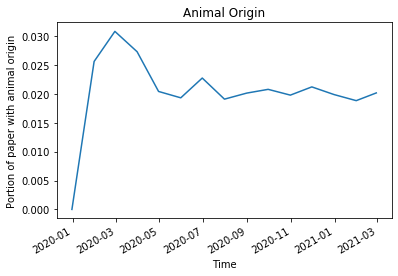

In [81]:
fig, ax = plt.subplots()

ax.plot(Animal_Origin.index, Animal_Origin)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Portion of paper with animal origin')

plt.title('Animal Origin')

plt.show()

fig.savefig('Animal_Origin.png')

plt.close(fig)

### Vaccine

Here, I show how the portion of publications that mentioned 'Vaccine' in tile or abstract changes over time.

In [82]:
Vaccine=DATA[['Publication ID','Vaccine','Date Created','Abstract']].dropna(subset=['Abstract'])

Vaccine=Vaccine[['Publication ID','Vaccine','Date Created']].drop_duplicates().reset_index(drop=True)

Vaccine=Vaccine.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Vaccine=Vaccine[['Vaccine']].agg('mean')

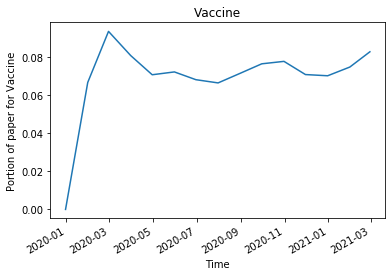

In [83]:
fig, ax = plt.subplots()

ax.plot(Vaccine.index, Vaccine)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Portion of paper for Vaccine')

plt.title('Vaccine')

plt.show()

fig.savefig('Vaccine.png')

plt.close(fig)

### Diagnostic

Here, I show how the portion of publications that mentioned 'Diagnostic' in tile or abstract changes over time.

In [84]:
Diagnostic=DATA[['Publication ID','Diagnostic','Date Created','Abstract']].dropna(subset=['Abstract'])

Diagnostic=Diagnostic[['Publication ID','Diagnostic','Date Created']].drop_duplicates().reset_index(drop=True)

Diagnostic=Diagnostic.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Diagnostic=Diagnostic[['Diagnostic']].agg('mean')

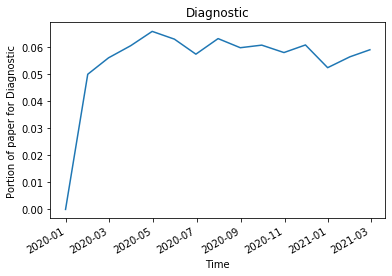

In [85]:
fig, ax = plt.subplots()

ax.plot(Diagnostic.index, Diagnostic)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Portion of paper for Diagnostic')

plt.title('Diagnostic')

plt.show()

fig.savefig('Diagnostic.png')

plt.close(fig)

### Industry Involvement

Next, I show how the portion of publications with industry involvement changes over time.

In [86]:
Industry_Involvement=DATA[['Publication ID','Industry','Date Created']].drop_duplicates().dropna(subset=['Industry']).reset_index(drop=True)

Industry_Involvement=Industry_Involvement.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Industry_Involvement=Industry_Involvement[['Industry']].agg('mean')

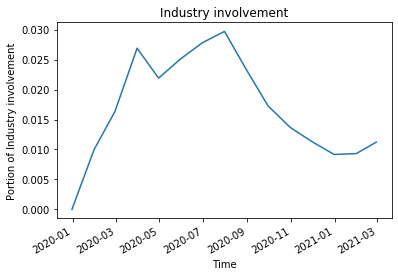

In [87]:
fig, ax = plt.subplots()

ax.plot(Industry_Involvement.index, Industry_Involvement)

fig.autofmt_xdate()

plt.xlabel('Time')

plt.ylabel('Portion of Industry involvement')

plt.title('Industry involvement')

plt.show()

fig.savefig('Industry_Involvement.png')

plt.close(fig)

### Length of publication

Now, I show how the length of publications changes over time. I show both the total number of pages and the average length of publication.

In [88]:
Length_Publication=DATA[['Publication ID','Length of publications','Date Created']].drop_duplicates().dropna(subset=['Length of publications']).reset_index(drop=True)

Length_Publication=Length_Publication.groupby(pd.Grouper(key="Date Created",freq='M', closed='left', label='left'))

Length_Publication_mean=Length_Publication[['Length of publications']].agg('mean')

Length_Publication_sum=Length_Publication[['Length of publications']].agg('sum')

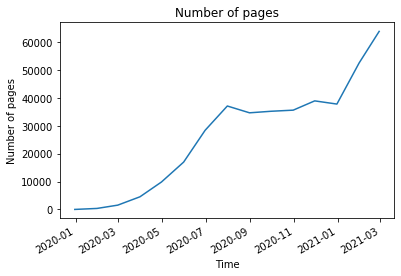

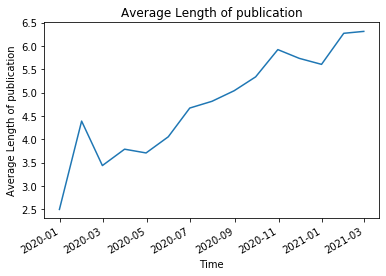

In [89]:
fig, ax = plt.subplots()

fig.autofmt_xdate()

plt.xlabel('Time')

plt.title('Number of pages')


ax.plot(Length_Publication_sum.index, Length_Publication_sum)

plt.ylabel('Number of pages')

plt.show()

fig.savefig('Length_Publication_sum.png')

plt.close(fig)


fig, ax = plt.subplots()

fig.autofmt_xdate()

plt.xlabel('Time')

plt.title('Average Length of publication')

ax.plot(Length_Publication_mean.index, Length_Publication_mean)

plt.ylabel('Average Length of publication')

plt.show()

fig.savefig('Length_Publication_mean.png')

plt.close(fig)

### Income group

Next, I look into what portion of publications are written by authors from countries in different income groups. To do that first I calculate the portion of authors in each income group. We should notice that if a publication has authors from more than one country, each country will be counted separately. Since the number of publications from the United States is uniquely high, I separate it from other high-income countries and put it in its own category.

In [90]:
Income_Group=DATA[['Publication ID','Countries','Income group','Date Created']].drop_duplicates().dropna(subset=['Income group']).reset_index(drop=True)

for i in range(Income_Group.shape[0]):
    if Income_Group.loc[i,'Countries']=='United States':
        Income_Group.loc[i,'Income group']='United States'
        
Income_Group=Income_Group.groupby([pd.Grouper(key="Date Created",freq='M', closed='left', label='left'),'Income group'])

Income_Group=Income_Group.agg({'Income group': 'count'})

Income_Group["Percentage"]=Income_Group.groupby(level=0).apply(lambda x:  100*x / x.sum())

Income_Group=Income_Group[['Percentage']]

Then I create a DataFrame with a percentage of publications in each income group.

In [91]:
Date_index=np.unique(Income_Group.index.get_level_values('Date Created'))

Income_index=np.unique(Income_Group.index.get_level_values('Income group'))

Mux=pd.MultiIndex.from_product([Date_index, Income_index], names=('Date Created', 'Income group'))

Income_Group=Income_Group.reindex(Mux, fill_value=0)


Pr_Income=pd.DataFrame()

for el in Income_index:
    Pr_Income[el]=Income_Group.loc[(Date_index,el),:]['Percentage'].droplevel(level=1)

In the end, I order the columns the way I want them to be shown in the figure and draw the stack plot.

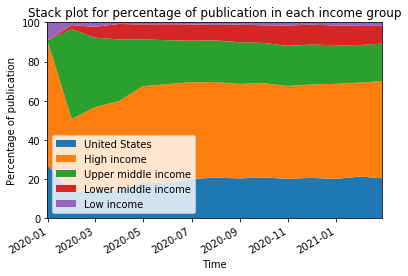

In [92]:
Pr_Income=Pr_Income[['United States','High income','Upper middle income','Lower middle income','Low income']]

fig, ax = plt.subplots()

ax.stackplot(Date_index, Pr_Income.to_numpy().transpose(),labels=Pr_Income.columns)

fig.autofmt_xdate()

plt.legend(loc='lower left')

plt.margins(0,0)

plt.title('Stack plot for percentage of publication in each income group')

plt.xlabel('Time')

plt.ylabel('Percentage of publication')

plt.show()

fig.savefig('Income_group.png')

plt.close(fig)

#### Extra codes for testing:

In [38]:
#df.sort_values(by=['Length of publications'], ascending=True, na_position='last')

In [39]:
#data[(data['Income group'].isnull()) & (data['Countries']!='')]

In [40]:
#Group_Keys=Income_Group.groups.keys()

#Income_Group.get_group('2016-01-31')

In [32]:
#try:
#    Pages[col][j]=roman_to_int(Pages[col][j])
#except:
#    print(j)

In [1]:
#for i in range(10):
#    print('\r', i , end='')
#    time.sleep(0.2)

In [ ]:
#pip install -U googlemaps

In [ ]:
#ind=data[data.Countries=='Kleger) equal contribution and joint supervision'].index
#ind=ind[0]
#test=df.loc[ind,'Source']
#test

In [41]:
#One_Health=DATA[['Publication ID','One_Health','Date Created']].drop_duplicates().dropna(subset=['One_Health']).reset_index(drop=True)
#print(len(One_Health))
#print(len(One_Health[One_Health.One_Health]))